In [209]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
import IPython
import pretty_midi
from tqdm.notebook import tqdm
from pqdm.processes import pqdm
import warnings

In [2]:
samplerate = 44.1e3

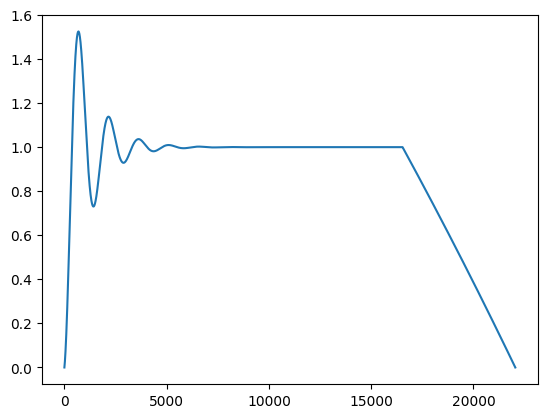

In [300]:
piano_window_defaults = (40, 2 * np.pi * 30, 0.25)

def piano_window(N, fs, b, wn, fall = 0.3):
    ts = np.linspace(0, N / fs, int(N))
    attack = np.exp(-b * ts) * np.sin(wn * ts + 1.5 * np.pi) + 1
    falloff_start = int(N*(1-fall))
    duration = N / fs
    a = attack[falloff_start] * np.exp(duration) / (np.exp(duration) - np.exp(falloff_start/fs))
    falloff = a * (1 - np.exp(ts - duration))
    window = attack
    window[falloff_start:] *= falloff[falloff_start:]
    window[window < 0] = 0
    return window

plt.figure()
plt.plot(piano_window(samplerate/2, samplerate, *piano_window_defaults));

In [ ]:
def midi_to_freq(code):
    return 2**((code-69)/12.0) * 440

def make_note(f0, coeffs, t):
    signal = np.sin(2 * np.pi * f0 * t)
    for k in range(len(coeffs)):
        signal += coeffs[k] * np.sin(2 * np.pi * (k+2)*f0 * t)
    return signal

timbre_defaults=[.3,.8,.2,.4,.2,.2,.1,.1]

def make_chord(midi_codes, timbre=timbre_defaults, piano_parameters=piano_window_defaults, duration=0.5):
    t = np.linspace(0, duration, int(duration * samplerate))
    y = np.zeros_like(t)
    for code in midi_codes:
        if code is not None:
            f0 = midi_to_freq(code)
            note = make_note(f0, timbre, t)
            y = note * piano_window(np.size(note), samplerate, *piano_parameters)
    return t, y

t, p = make_chord([69])
IPython.display.Audio(p, rate=samplerate)

In [ ]:
midi_data = pretty_midi.PrettyMIDI('song.mid')
duration = midi_data.get_end_time()

def make_melody(instrument):
    sound = np.zeros(int(duration*samplerate+1))
    for note in instrument.notes:
        _, chord = make_chord([note.pitch], duration=note.end-note.start)
        sound[int(note.start*samplerate):int(note.start*samplerate)+len(chord)] += chord
    return sound

warnings.filterwarnings('ignore')
sounds = pqdm(midi_data.instruments, make_melody, n_jobs=len(midi_data.instruments))
sound = np.sum(sounds, axis=0)

In [ ]:
IPython.display.Audio(sound[:np.size(sound)], rate=samplerate)

In [ ]:
plt.figure()
plt.specgram(sound , Fs = samplerate, NFFT = 1000)
plt.ylim(0, 20000);